<a href="https://colab.research.google.com/github/kankeinai/Portfolio-Selection-Problem/blob/main/LP_Financial_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Application of Linear programming in Finance

##Introduction

In this jupyter notebook, we are going to investigate how linear programming can be used in order to solve portfolio selection problem.

In [1]:
# import all needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.optimize import linprog

# connect google drive to access file with data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We are going to apply algorithms to the small dataset provided by the book "Linear Programming: Foundations and Extensions" by Robert J. Vanderbei.

We copied it and stored in a .csv file.

##Extract and prepare data

In [2]:
# take data from 2ms to 6 ms, as it was requested and drop column time, 
# since it's not needed anymore

data = pd.read_csv('/content/drive/MyDrive/LP Project/Financial data - Sheet1.csv')

data

,Year- Month,SHY Bonds,XLB Materials,XLE Energy,XLF Financial,XLI Indust.,XLK Tech.,XLP Staples,XLU Util.,XLV Health
0,2007-04,1.000,1.044,1.068,1.016,1.035,1.032,1.004,0.987,1.014
1,2007-03,1.003,1.015,1.051,1.039,1.046,1.047,1.028,1.049,1.073
2,2007-02,1.005,1.024,1.062,0.994,1.008,1.010,1.021,1.036,1.002
3,2007-01,1.007,1.027,0.980,0.971,0.989,0.973,0.985,1.053,0.977
4,2006-12,1.002,1.040,0.991,1.009,1.021,1.020,1.020,0.996,1.030
5,2006-11,1.001,0.995,0.969,1.030,0.997,0.989,1.020,0.999,1.007
6,2006-10,1.005,1.044,1.086,1.007,1.024,1.028,0.991,1.026,0.999
7,2006-09,1.004,1.060,1.043,1.023,1.028,1.040,1.018,1.053,1.003
8,2006-08,1.004,1.000,0.963,1.040,1.038,1.040,0.999,0.985,1.015
9,2006-07,1.008,1.030,0.949,1.012,1.011,1.070,1.039,1.028,1.029


As we can see we are provided monthly returns if we invest $1\$$ in some particular month to particular asset.

In [3]:
# time, needed for time-series plot
time = np.array(data['Year- Month'].values)

# time doesn't matter in calculations => drop it
data.drop(columns=["Year- Month"], inplace=True)
returns = np.array(data.values)

# names of assets 
titles = data.columns

# T – number of time steps, n – number of assets  
T, n = returns.shape

## Draw data

It is always a good practice to draw data to get some insigths.

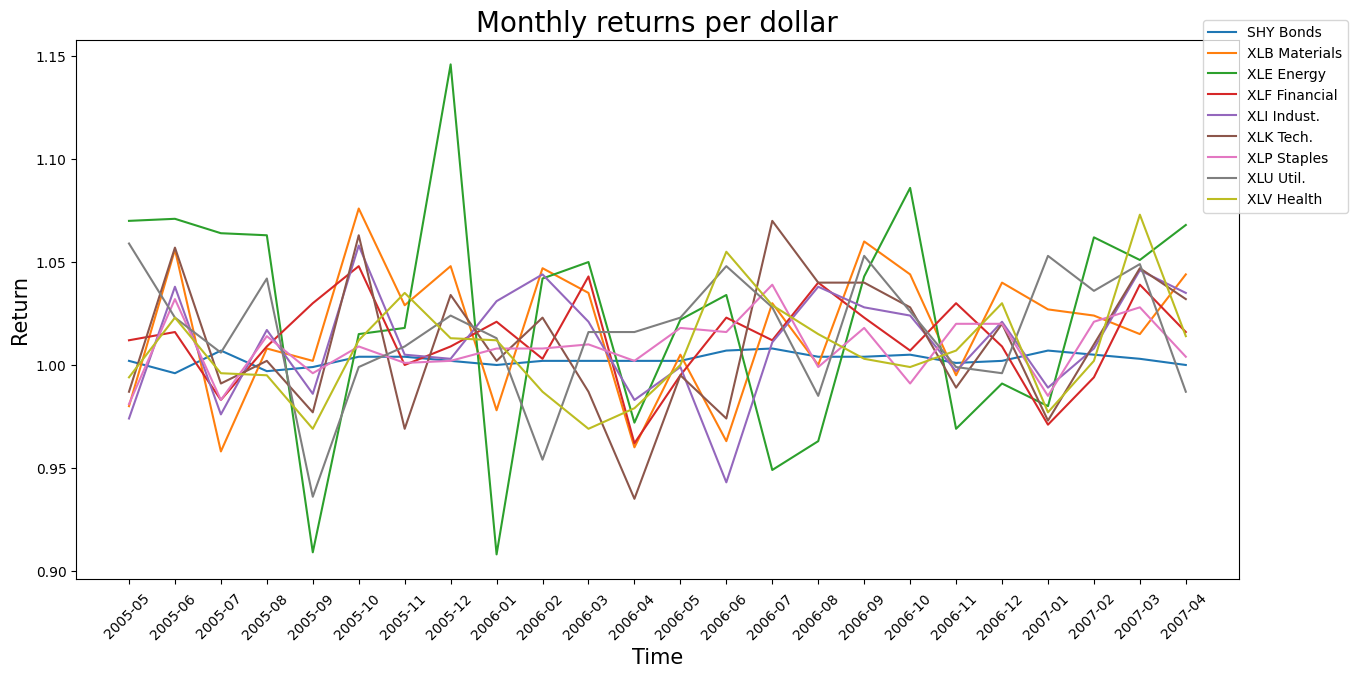

In [4]:
# draw loss graphs for training and test datasets

fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title(f'Monthly returns per dollar',fontsize=20)
ax.set_xlabel('Time',  fontsize=15)
ax.set_ylabel(f'Return',  fontsize=15)

for i in range(n):

    ax.plot(time[::-1], returns[::-1].T[i], label=f"{titles[i]}")

for tick in ax.get_xticklabels():
    tick.set_rotation(45)    

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

As we can see from the graphs, some of the assets are very stochastic, but some are more or less stable.

But how we can decide how many percentage invest in each asset given we are ready to risk with risk parameter $\mu$.

##Portfolio Selection problem

This is so called portfolio selection problem. And this can be stated as optimization problem:

\begin{align}
   &\text{maximize } \mu\sum_j{x_j\mathbb{E}R_j} - \mathbb{E}\sum_{j}\left|x_j \tilde R_j \right| \\
   &\text{subject to } \sum_j{x_j} = 1, \ x_j \geq 0,\quad j=1,2,\dots n  \\
\end{align}

Where $\tilde R_j = R_j - \mathbb{E}R_j$ and $\mathbb{E}R$ denotes expected value. $\mu$ is a risk aversion parameter. 

For simplicity, given some historical data we can approximate expected value $$\mathbb{E}R_j = \frac{1}{T}\sum_{t=1}^{T}{R_j(t)}.$$

#Portfolio Selection given known historical data

\begin{align}
   &\text{maximize } \mu\sum_j{x_jr_j} - \frac{1}{T}\sum_{t=1}^T\left|{\sum_j{x_j\left(R_j(t)-r_j\right)}}\right| \\
   &\text{subject to } \sum_j{x_j} = 1, \ x_j \geq 0,\quad j=1,2,\dots n  \\
\end{align}

Where $r_j = \frac{1}{T}\sum_{t=1}^T R_j(t)$ denotes expected reward for asset $j$.

Now, we can further simplify expression by defining
$$y_t = \left|{\sum_j{x_j\left(R_j(t)-r_j\right)}}\right|$$
Since, it is equality constraint we can rewrite it as:
$$y_t \leq {\sum_j{x_j\left(R_j(t)-r_j\right)}}$$
$$y_t \geq {\sum_j{x_j\left(R_j(t)-r_j\right)}}$$

So final Linear Programming problem can be expressed as:

\begin{align}
   \text{maximize: } &\mu\sum_j{x_jr_j} - \frac{1}{T}\sum_{t=1}^T y_t \\
   \text{subject to: } &{\sum_j{x_j\left(R_j(t)-r_j\right)}} \leq y_t \\
   &-{\sum_j{x_j\left(R_j(t)-r_j\right)}} \leq y_t \\
    &\sum_j{x_j} = 1, \quad x_j \geq 0 \quad  j=1,2,\dots n  \\
    &y_t \geq 0 \quad  t=1,2,\dots T
\end{align}

In [5]:
# formula for r
r = lambda j: np.mean(returns[:, j])

How to solve such problem? 

#Naive: Solution via Simplex Method (by varying parameter)

Just set $\mu$ to some known number and solve it via simplex method. Python already has some known implementations to solve linear programming problems. We just need to formulate problem in a matrix form.

I will set first $n$ variables to denote $x_j$ for $j=0\dots n-1$ and next $T$ variables for $y_i$ for $i=0\dots T-1$.

In [6]:
def create_lp(mu):

    # let z be coefficient of variables in objective function (easy)
    z = np.array([r(i)*mu for i in range(n)]  + [-1/T]*T)

    # let b be coefficient of variables in objective function (easy)
    b = np.array([0]*(2*T) + [1])

    #coefficients of variables in the constraints
    constraint = []

    for t in range(T):

        temp = [0 for i in range(T)]
        temp[t] = -1
        constraint.append(np.array([returns[t, j]-r(j) for j in range(n)] + temp))
        constraint.append(np.array([-(returns[t, j]-r(j)) for j in range(n)] + temp ))

    # last constraint without y
    constraint.append(np.array([1]*n+[0]*(T)))

    return z, b, np.array(constraint)

In [7]:
# set μ, write problem in a matrix form
mu = 1
z, b, A = create_lp(mu)

# use function to solve LP

# Note: function is used for minimization problems, so 
# pass objective function with '–'
# A_ub, b_ub notation used when passed problem is with less/or equal signs

res = linprog(-z, A_ub=A, b_ub=b)
res

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -1.0036154835427797
              x: [ 0.000e+00  2.139e-01 ...  1.408e-02  0.000e+00]
            nit: 38
          lower:  residual: [ 0.000e+00  2.139e-01 ...  1.408e-02
                              0.000e+00]
                 marginals: [ 7.989e-04  0.000e+00 ...  0.000e+00
                              3.052e-02]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [-0.000e+00 -3.413e-02 ... -1.115e-02
                             -1.004e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mi

First $n$ number of `res.x` will return values of $x$ and next values are for $y$.


In [8]:
print(f"With risk parameter 𝜇={mu}\n--------------------------")
for i, j in zip(res.x[:n], titles):
    print(f"{j}: {i*100:.3f}%")

With risk parameter 𝜇=1
--------------------------
SHY Bonds: 0.000%
XLB Materials: 21.390%
XLE Energy: 0.000%
XLF Financial: 42.606%
XLI Indust.: 2.593%
XLK Tech.: 0.000%
XLP Staples: 7.453%
XLU Util.: 25.958%
XLV Health: 0.000%


So, if we repeat this problem for many values of $\mu$, we can construct an efficient frountier of this portfolio selection problem.




In [9]:
mu = np.linspace(0, 10, 1000)
result = []

for val in mu:

    z, b, A = create_lp(val)
    res = linprog(-z, A_ub=A, b_ub=b)
    result.append(res.x[:n])

values = np.array(result).T

In [10]:
def generate_frontier(mu, values):
    
    weight_counts =  {titles[i]: values[i] for i in range(n)}
    width = mu[1]-mu[0]

    fig, ax = plt.subplots(figsize = (12,10))
    bottom = np.zeros(len(mu))

    for boolean, weight_count in weight_counts.items():
        p = ax.bar(mu, weight_count, width, label=boolean, bottom=bottom)
        bottom += weight_count

    ax.set_title("Optimal portfolios as a function of risk parameter μ")
    ax.legend(bbox_to_anchor=(1.1, 1.05) )
    plt.show()


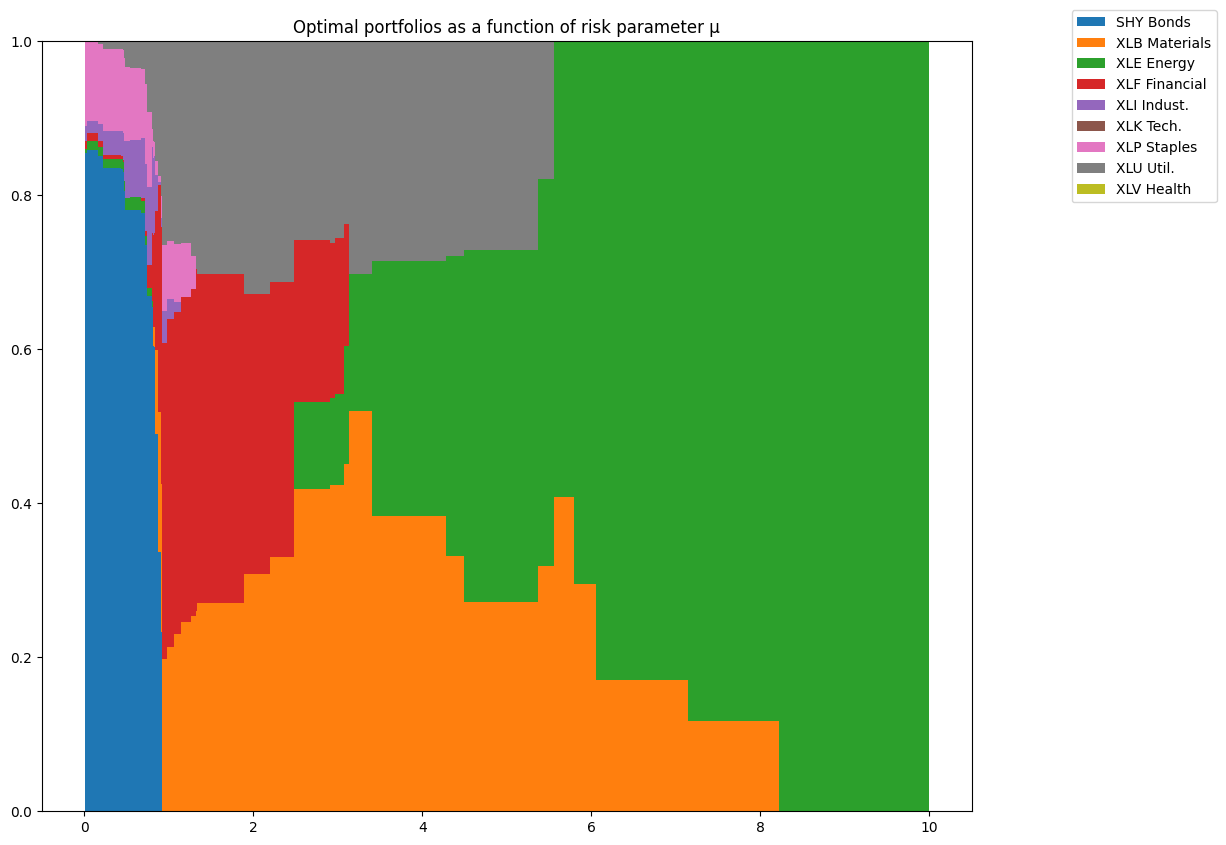

In [11]:
values = np.array(result).T

generate_frontier(mu, values)

From this plot, we can see that for some ranges of $\mu$ we do redundant calculations. If we could solve problem for some ranges of $\mu$, it would speed up calculations and provided a more accurate solution. 

In case of naive approach, we can state that our solution is accurate with step $\pm 0.01$, but it required to solve LP problem $1000$ times. We can do better.

#Solution via Parametric Simplex Method

Let us introduce slack variables $w_t^+$ and $w_t^-$:

\begin{align}
   \text{maximize: } &\mu\sum_j{x_jr_j} - \frac{1}{T}\sum_{t=1}^T y_t \\
   \text{subject to: } &-y_t -{\sum_j{x_j\left(R_j(t)-r_j\right)}} + w_t^- = 0  \\
   &-y_t + {\sum_j{x_j\left(R_j(t)-r_j\right)}} + w_t^+= 0 \\
    &\sum_j{x_j} = 1, \quad x_j \geq 0 \quad  j=1,2,\dots n  \\
    &y_t \geq 0, \ w_t^- \geq 0,  \ w_t^+ \geq 0 \quad  t=1,2,\dots T
\end{align}

"It is easy to see that for $\mu$ larger than some threshold, the optimal solution is to put all of our portfolio into a single asset, the one with the highest expected reward $r_j$." (p. 188). Let $j^*$ denote the highiest reward asset, s.t.: $$r_j^* \geq r_j \quad \text{for all } j$$


In [12]:
rs = np.array([r(j) for j in range(n)])

for j in range(n):
    print(f"r_{j} = {rs[j]}")

j_star = np.argmax(rs)

r_0 = 1.0027083333333333
r_1 = 1.0176666666666667
r_2 = 1.02275
r_3 = 1.0122916666666666
r_4 = 1.0114583333333333
r_5 = 1.0102083333333332
r_6 = 1.0085416666666667
r_7 = 1.0158333333333334
r_8 = 1.0078333333333334


In [13]:
print(j_star)

2


NOTE: In python indexing starts from $0$.

It is easy to see that $j^* = 2$

If we look carefully, we see that we have $3T+n$ non-negative variables and $2T+1$ constraints. So, there are $(3T+n) - (2T+1) = T+n-1$ nonbasic variables and $2T+1$ basic variables.

Since, we innitialy assumed that we should invest everything to asset $j^*$, then $x_j^* = 1$ and $x_j = 0$ for the rest $j\neq j^*$. "We can then simply declare any variable that is positive to be basic and declare the rest to be nonbasic." (p. 189)

1. $x_j^*$ is basic, the remaining are non-basic.
2. $ w_t^- = y_t + (R_j^*(t)- r_{j^*})$
2. $ w_t^+ = y_t - (R_j^*(t)- r_{j^*}) $

Recall that $y_t  = \left|{\sum_j{x_j\left(R_j(t)-r_j\right)}}\right| = | R_j^*(t)- r_{j^*}|$. It is always positive, thus is basic.


$$w_t^- = y_t + (R_j^*(t)- r_{j^*})$$
$$ w_t^+ = y_t - (R_j^*(t)- r_{j^*}) $$

Now it obvious that if $R_j^*(t)- r_{j^*}>0$, then $w_t^-$ is basic and $w_t^+$ is non-basic. And reverse. 

For convinience, we can introduce next notation $$D_{tj} = R_j(t) - r_j$$
Then,
$$T^+ = \{t: D_{j^*t}>0\} \quad \text{and} \quad T^- = \{t: D_{j^*t} <0\}$$

$T^+$ denotes time when $w_t^-$ is basic and $w_t^+$ is non-basic and $T^-$ denotes time when $w_t^+$ is basic and $w_t^-$ is non-basic. 

Following the book, this is the optimal dictionary for this problem given $\mu$ is sufficiently LARGE:
<center>
<img src="https://i.ibb.co/swGkcsK/Screen-Shot-2023-04-13-at-04-18-28.png" alt="Screen-Shot-2023-04-13-at-04-18-28" border="0" width="60%">
</center>

In [14]:
D = lambda t, j: returns[t, j] - r(j)
D_matrix = np.array([[D(t, j) for j in range(n)] for t in range(T)])

T_plus = np.arange(T)[D_matrix[:, j_star]>0] 
T_minus = np.arange(T)[D_matrix[:, j_star]<0]

Let $$\epsilon_t = \begin{cases}1, \quad \text{for }t\in T^+\\-1, \quad \text{for }t\in T^-\end{cases}$$

In [15]:
def epsilon(t):
    if t in T_plus:
        return 1
    else:
        return -1

##Generate Matrix A

How matrix can look like?
1. n indices are reserved for $x$
2. T indices are reserved for $w^+$
3. T indices are reserved for $w^-$
4. T indices are reserved for $y$

In [16]:
def generate_row_for_y(t, T, n, j_star,D_matrix):

    row = np.zeros(n+3*T)

    if t in T_plus:
        for j in range(n):
            if j!= j_star:
                row[j] = D_matrix[t,j] - D_matrix[t,j_star]
        row[n+t] = 1
        row[n+2*T+t] = -1
    else:
        for j in range(n):
            if j!= j_star:
                row[j] = -(D_matrix[t,j] - D_matrix[t,j_star])
        row[n+T+t] = 1
        row[n+2*T+t] = -1
    
    return row

def generate_row_for_w(t, T, n, j_star,D_matrix):
    
    row = np.zeros(n+3*T)
    
    if t in T_plus:
        for j in range(n):
            if j != j_star:
                row[j] = 2*(D_matrix[t,j] - D_matrix[t,j_star])
        row[n+t] = 1
        row[n+T+t] = -1
    else:
        for j in range(n):
            if j != j_star:
                row[j] = -2*(D_matrix[t,j] - D_matrix[t,j_star])
        row[n+T+t] = 1
        row[n+t] = -1

    return row

def generate_row_for_x_star(n, T):

    row = np.zeros(n+3*T)

    for j in range(n):
        row[j] = -1

    return row

In [17]:
def generate_Matrix(T, n, j_star,D_matrix):
    matrix = [generate_row_for_y(t, T, n, j_star,D_matrix) for t in range(T)]+[generate_row_for_w(t, T, n, j_star,D_matrix) for t in range(T)]+[generate_row_for_x_star(n, T)]
    
    return np.array(matrix)


We need to check this size of matrix. For our current problem, we have $3T+n$ variables and $2T+1$ constraints.

In [18]:
print(f"Current number of variables: {generate_Matrix(T, n, j_star,D_matrix).shape[1]} and number of constraints: {generate_Matrix(T, n, j_star,D_matrix).shape[0]}")
print(f"Expected number of variables: {3*T+n} and number of constraints: {2*T+1}")

Current number of variables: 81 and number of constraints: 49
Expected number of variables: 81 and number of constraints: 49


Everything is fine!

In [19]:
A = generate_Matrix(T, n, j_star,D_matrix)

##Generate vector b

In [20]:
def generate_b():
    b = []
    
    for t in range(T):
        if t in T_plus:
            b.append(-D_matrix[t, j_star])
        else:
            b.append(D_matrix[t, j_star])

    for t in range(T):

        if t in T_plus:
            b.append(-2*D_matrix[t, j_star])

        else:
            b.append(2*D_matrix[t, j_star])
            
    b.append(-1)

    return np.array(b).reshape(-1,1)

For now, we have matrix $A$ of dimentsion [49, 81] and vector $b$ of size 49. We have $81$ variables.

So we translated our constraints into matrix form:
$$Ax = b$$

Let $B$ be set of basic variables and $N$ set of non-basic variables.

In [21]:
B = []
N = []

x_idx = list(np.arange(n))
x_idx.pop(j_star)

w_plus_idx = np.arange(n, n+T)
w_minus_idx = np.arange(n+T, n+2*T)
y_idx = np.arange(n+2*T, n+3*T)

Basic variable from $w_t^+$ are those where $t\in T^-$.
Basic variable from $w_t^-$ are those where $t\in T^+$.

All $y$ are basic and $x_j^*$ is basic.

In [22]:
B = list(y_idx)+ list(w_plus_idx[T_minus])+list(w_minus_idx[T_plus]) + [j_star]
B.sort()


In [23]:
N = list(w_plus_idx[T_plus])+list(w_minus_idx[T_minus]) + x_idx
N.sort()

We are ready to proceed!

In [24]:
len(B)+len(N)

81

Let's start from some notation:
$$\zeta = \zeta^* - (z^*_N+\mu \bar z_N)^Tx_N$$
$$x_B = (x_B^*+\mu\bar x_B) - B^{-1}Nx_N$$

Since we are solving parametric simplex method, we assume that we use some pertubations. If we return to original problem, we recall that:

$$x_j\left(\mu(r_j-r_{j^*})-\frac{1}{T}\sum_{t=0}^T{\epsilon_t\left(D_{tj}-D_{tj^*}\right)}\right), \quad \text{for } j\neq j^*  $$

But the same can be understood as:

$$x_j(a_j+\mu\bar a_j)$$

And note that we add this pertubation only to objective function and only to $x_j$, which means that essentialy $$\bar x_B = 0$$

In [25]:
def define_pertubations():

    z_bar = np.zeros(len(N)+len(B))
    x_bar = np.zeros(len(B)+len(N))

    for j in range(n):
        if j!= j_star:
            z_bar[j] = -(r(j) - r(j_star))

    # I added some small number to x_bar, so that we don't
    # encounter devision by 0 problem somewhere
    # it is sufficiently small

    return z_bar.reshape(-1,1), (x_bar+1e-12).reshape(-1,1)

They both are strictly positive.

<center>
<img src="https://i.ibb.co/swGkcsK/Screen-Shot-2023-04-13-at-04-18-28.png" alt="Screen-Shot-2023-04-13-at-04-18-28" border="0" width="60%">
</center>

At the moment forget about pertubed value and write vector $c$ as coefficients in the objective function: 

In [26]:
def generate_c():

    row = np.zeros(len(N)+len(B))

    for j in range(n):
        if j!=j_star:
            row[j] = -np.mean([epsilon(t)*(D_matrix[t, j]- D_matrix[t, j_star])for t in range(T)])
    
    for t in range(T):
        if t in T_plus:
            row[n+t] = -1/T
        else:
            row[n+T+t] = -1/T
            
    return row.reshape(-1, 1)


Define a super big combining everything function!

In [27]:
def generate_parametric(T, n, j_star, D_matrix):

    A = generate_Matrix(T, n, j_star,D_matrix)
    c = generate_c()
    b = generate_b()

    B = np.array(list(y_idx)+ list(w_plus_idx[T_minus])+list(w_minus_idx[T_plus]) + [j_star])
    N = np.array(list(w_plus_idx[T_plus])+list(w_minus_idx[T_minus]) + x_idx)

    B.sort()
    N.sort()

    z_bar, x_bar = define_pertubations()

    return A, c, b, z_bar, x_bar, B, N

In [28]:
A, c, b, z_bar_N, x_bar_B, B, N = generate_parametric(T, n, j_star, D_matrix)

Recall that in matrix form:
$$z^*_N = (B^{-1}N)^Tc_B-c_N$$
$$x^*_B= B^{-1}b$$

In [29]:
def z_star_calc(A, B, N, c):
    return (inv(A[:, B])@(A[:, N])).T@c[B] - c[N]

def x_star_calc(A, B, b):
    return inv(A[:, B])@b

With pertubations it will be:
$$ζ = ζ^∗ − ( z^*_N + μ\bar z_N)^T x_N$$
$$x_B = x^∗_B + μ\bar x_B $$


<center><img src="https://i.ibb.co/HdNQLdr/Screen-Shot-2023-04-24-at-03-03-18.png" alt="Screen-Shot-2023-04-24-at-03-03-18" border="0"></center>

In [30]:
def mu_calc(z_star_N, z_bar_N, x_star_B, x_bar_B):

    # we are interested only in positive pertubations
    idx_1 = np.arange(len(z_bar_N)).reshape(-1,1)[z_bar_N > 0]
    idx_2 =  np.arange(len(x_bar_B)).reshape(-1,1)[x_bar_B > 0]

    # max value by z ratio
    val_1 = -z_star_N[idx_1]/z_bar_N[idx_1]
    temp_1_idx = idx_1[np.argmax(val_1)]
    max_temp_1 = max(val_1)

    # max value by x ratio
    val_2 = -x_star_B[idx_2]/x_bar_B[idx_2]
    temp_2_idx = idx_2[np.argmax(val_2)]
    max_temp_2 = max(val_2)

    if max_temp_1 > max_temp_2:
        return max_temp_1, temp_1_idx, 'j'
    else:
        return max_temp_2, temp_2_idx, 'i'

In Linear programming there is an assumption that $0/0 = 0$

In [31]:
def div_by_0(a, b):
    if b==0:
        if a==0:
            return 0
    else:
        return a/b

def devide(a, b):
    return np.array([div_by_0(i, j) for i,j in zip(a,b)])

In [32]:
def solve_portfolio_selection():
    result = {'mu':[], 'x':[]}

    A, c, b, z_bar, x_bar, B, N = generate_parametric(T, n, j_star,D_matrix)

    z_star = np.zeros(len(B)+len(N)).reshape(-1,1)
    np.put(z_star, N, z_star_calc(A, B, N, c))

    x_star = np.zeros(len(B)+len(N)).reshape(-1,1)
    np.put(x_star, B, x_star_calc(A, B, b))

    mu, idx, way = mu_calc(z_star[N], z_bar[N], x_star[B], x_bar[B])

    while mu>0:

        print(f"Got μ={mu} with {way}")

        x = np.zeros(n)
        np.put(x, B[B<n], x_star[B[B<n]])
        result['x'].append(x)
        result['mu'].append(float(mu))

        if way=='j':
            j = idx
            delta_x_B = inv(A[:,B])@A[:,N]@np.eye(len(N))[j].reshape(-1,1)
            i = np.argmax(devide(delta_x_B,(x_star[B]+mu*x_bar[B])).reshape(-1,1))
            delta_z_N = -(inv(A[:,B])@A[:,N]).T@np.eye(len(B))[i].reshape(-1,1)
        else:
            i = idx
            delta_z_N = -(inv(A[:,B])@A[:,N]).T@np.eye(len(B))[i].reshape(-1,1)
            j = np.argmax(devide(delta_z_N,(z_star[N]+mu*z_bar[N])).reshape(-1,1))
            delta_x_B = inv(A[:,B])@A[:,N]@np.eye(len(N))[j].reshape(-1,1)

        t = x_star[B[i]]/delta_x_B[i]
        t_bar = x_bar[B[i]]/delta_x_B[i]
        s = z_star[N[j]]/delta_z_N[j]
        s_bar = z_bar[N[j]]/delta_z_N[j]

        x_star[N[j]] = t
        x_bar[N[j]] = t_bar
        z_star[B[i]] = s
        z_bar[B[i]] = s_bar

        np.put(x_star, B, x_star[B] - t * delta_x_B)
        np.put(x_bar, B, x_bar[B] - t_bar * delta_x_B)
        np.put(z_star, N, z_star[N] - s * delta_z_N)
        np.put(z_bar, N, z_bar[N] - s_bar * delta_z_N)

        temp = B[i]
        B[i] = N[j]
        N[j] = temp

        mu, idx, way = mu_calc(z_star[N], z_bar[N], x_star[B], x_bar[B])

    x = np.zeros(n)
    np.put(x, B[B<n], x_star[B[B<n]])
    result['x'].append(x)    
    result['mu'].append(float(mu))

    return result

In [33]:
result = solve_portfolio_selection()

Got μ=[8.22814208] with j
Got μ=[7.14480874] with j
Got μ=[6.06420765] with j
Got μ=[5.80054645] with j
Got μ=[5.56497148] with j
Got μ=[5.36880545] with j
Got μ=[4.4969883] with j
Got μ=[4.27511672] with j
Got μ=[3.40551329] with j
Got μ=[3.12384171] with j
Got μ=[3.08002269] with j
Got μ=[2.96786119] with j
Got μ=[2.91272083] with j
Got μ=[2.48154552] with j
Got μ=[2.19448264] with j
Got μ=[1.88425094] with j
Got μ=[1.33811196] with j
Got μ=[1.31718793] with j
Got μ=[1.26691177] with j
Got μ=[1.1433239] with j
Got μ=[1.06154157] with j
Got μ=[0.97873007] with j
Got μ=[0.91825965] with j
Got μ=[0.90859286] with j
Got μ=[0.87015168] with j
Got μ=[0.83724481] with j
Got μ=[0.8244409] with j
Got μ=[0.81084426] with j
Got μ=[0.80214914] with j
Got μ=[0.73841891] with j
Got μ=[0.71185088] with j
Got μ=[0.71175258] with j
Got μ=[0.71136415] with j
Got μ=[0.6732531] with j
Got μ=[0.54468205] with j
Got μ=[0.48477408] with j
Got μ=[0.46372148] with j
Got μ=[0.45348669] with j
Got μ=[0.435877]

Ignore last 3 values since they appeared because of small pertubation of $x$ in constraints.

In [36]:
mu_val = np.array(result['mu'])[::-1]

ranges = []

for i in range(1, len(mu_val)):
    ranges.append(f"[{mu_val[i-1]:.7f}-{mu_val[i]:.7f})")

ranges.append(f">={mu_val[-1]:.7f}")
res = dict(map(lambda i,j : (i,j), titles, np.array(result['x'])[::-1][3:].T))
res['Risk parameter μ'] = ranges[3:]
print(pd.DataFrame(res).to_string())

    SHY Bonds  XLB Materials  XLE Energy  XLF Financial  XLI Indust.  XLK Tech.  XLP Staples  XLU Util.  XLV Health       Risk parameter μ
0    0.855048       0.000000    0.005236       0.010056     0.020208        0.0     0.109452   0.000000         0.0  [0.0000065-0.0385428)
1    0.859255       0.000000    0.011788       0.009312     0.016113        0.0     0.103532   0.000000         0.0  [0.0385428-0.1588256)
2    0.851285       0.000000    0.011909       0.007713     0.021378        0.0     0.104584   0.003131         0.0  [0.1588256-0.2153603)
3    0.835160       0.000000    0.012154       0.004478     0.032030        0.0     0.106713   0.009466         0.0  [0.2153603-0.4358770)
4    0.834627       0.000000    0.012368       0.004322     0.032341        0.0     0.106616   0.009726         0.0  [0.4358770-0.4534867)
5    0.830527       0.000000    0.012225       0.003549     0.035090        0.0     0.107324   0.011286         0.0  [0.4534867-0.4637215)
6    0.805637       0.00000

So, using parametric simplex method, we achieved more accurate results by solving problem $42$ times vs $1000$. 

The results are also coincide with our intuition about the problem.